## Week 5: Logistic Regression - multiclass

Instructor: Cornelia Paulik <br>
Email: cpaulik@ischool.berkeley.edu <br>

---
#### ``Readings``

1. Raschka & Mirjalili (RM), 3rd edition: Chapter 3 (pp. 60-78), Chapter 6 (pp.211-222) in the print version of the book.

#### ``Learning Objectives``

1. Define supervised learning as a machine learning approach where a logistic regression model learns from multi labeled data to make predictions;

3. Illustrate how logistic regression can be used to predict wine cultivar classes.

#### ``Data``

[Source and data description](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data): these data results from a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. The attributes are alcohol, malic acid, ash, alcalinity of ash, magnesium, total phenols, flavonoids, nonflavonoid phenols, proanthocyanins, color intensity, hue, OD280/OD315 of diluted wines, and proline.

We will restrict our attention to two class labels (cultivar 0 and 1) and two features ('alcohol' and 'OD280/OD315_of_diluted_wines') for today's class.

### Step 1: Import packages

I am using the following package versions:
* Pandas: 2.2.2
* Numpy: 1.26.4
* Matplotlib: 3.8.4
* Seaborn: 0.13.2
* Sklearn: 1.4.2
* IPython: 8.25.0
* Mlxtend: 0.23.3
* Tensorflow: 2.17.0
* Statsmodels: 0.14.2

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# statsmodels
import statsmodels.api as sm

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

random.seed(2)

### Step 2: Define functions

In [2]:
def read_wine_data():
    """Read the wine dataset from 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
    # param: None
    # return df and X,y np.arrays for training and test (cleaning included)
    """
    # read data
    df = pd.read_csv('https://archive.ics.uci.edu/'
                          'ml/machine-learning-databases/wine/wine.data',
                          header=None)

    # define columns
    df.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
                  'alcalinity_of_ash', 'magnesium', 'total_pphenols',
                  'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
                  'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
                  'proline']

    print('Shape of df wine:', df.shape)
    
    return df

In [3]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [4]:
def compute_generalized_correlation(class_dummies, X):
    # To fit a regression, we must treat the three class dummies as inputs, and a single predictors as output
    model = sm.OLS(X, class_dummies).fit()  
    return(np.sqrt(model.rsquared))

In [5]:
def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(3))
    plt.yticks([])
    plt.title('ground truth: ' + str(true_label))
    thisplot = plt.bar(range(3), predictions_array, color="#777777")
    plt.ylim([0, 1])
    
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

---
### Step 3: Read data
---

In [6]:
df = read_wine_data()
df.head()

Shape of df wine: (178, 14)


,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The original data contains 178 observations and 13 features.

---
### Step 4: Data preprocessing

---

``labels and features``

In [7]:
# recode class labels (from 0 to 2 instead of 1 to 3)
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.class_label))}
class_mapping

df['class_label'] = df.class_label.map(class_mapping) # notice how we use all 3 classes
labels = ['class_label']

# select only 2 features (easier to visualize features and decission bounderies in a 2D space)
features = ['alcohol', 'OD280/OD315_of_diluted_wines']

# ansamble data
df = df[labels+features]

# print data and shapes
print('Class labels:', df['class_label'].unique())
print('Features:', df.columns[1:])
print('Shape of data', df.shape)
df.head()

Class labels: [0 1 2]
Features: Index(['alcohol', 'OD280/OD315_of_diluted_wines'], dtype='object')
Shape of data (178, 3)


,class_label,alcohol,OD280/OD315_of_diluted_wines
0,0,14.23,3.92
1,0,13.20,3.40
2,0,13.16,3.17
3,0,14.37,3.45
4,0,13.24,2.93


``split data into training, validation and test``

In [8]:
# define outcome #
##################
y = df['class_label'].values

# define features #
###################
X = df[['alcohol', 'OD280/OD315_of_diluted_wines']].values

# split #
#########
# set seed for consistent behavior
# set seed for consistent behavior
tf.random.set_seed(1234)
np.random.seed(1234)
splits = (0.6,0.2, 0.2)
shuffle = np.random.permutation(np.arange(y.shape[0]))
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), splits).astype(int)
X_train, X_val, X_test = np.split(X, [splits[0], splits[0]+splits[1]])
y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

print('Size of X_train', X_train.shape)
print('Size of y_train', y_train.shape)
print('Size of X_val', X_val.shape)
print('Size of y_val', y_val.shape)
print('Size of X_test', X_test.shape)
print('Size of y_test', y_test.shape)


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['class_label', 'alcohol', 'OD280/OD315_of_diluted_wines']

Size of X_train (106, 2)
Size of y_train (106,)
Size of X_val (35, 2)
Size of y_val (35,)
Size of X_test (37, 2)
Size of y_test (37,)


``feature scalling for optimal performance``

standardization: center the feature columns at mean 0 and std 1. Prefered over normalization, as it preservers useful information about outliers and makes the algorithm less sensitive to them. This is what we will be implementing today.

In [9]:
# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_val_std = sc_x.fit(X_train).transform(X_val)
X_test_std = sc_x.fit(X_train).transform(X_test)

Note how we fit the StandardScaler() only on the training data, and use the mean and sd parameters to transform the test data!

---
### Step 5: Exploratory Data Analysis (EDA)
---

Prior to training a model it is important to perform exploratory data analysis. The idea is to detect any missing data, the presence of outliers, the feature distribution, and the relationship between features and outcome. Note that typically there is a back and forth between Step 4 and 5, depending on how satisfied you are with the results of the EDA.

In [10]:
df_train.isna().sum()

class_label                     0
alcohol                         0
OD280/OD315_of_diluted_wines    0
dtype: int64

``correlation matrix of outcome and feature variables``

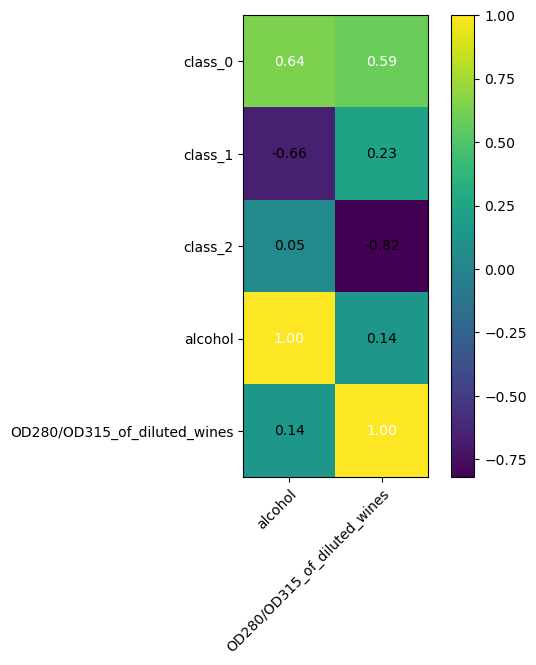

In [11]:
df_train_with_dummies = pd.get_dummies(df_train.class_label, prefix='class').join( df_train.drop('class_label', axis=1))
cm = df_train_with_dummies.corr()[['alcohol','OD280/OD315_of_diluted_wines']]

hm = heatmap(
    cm.values,
    row_names=cm.index,
    column_names=cm.columns,
    figsize=(6, 6)
)
plt.show()

<span style="color:chocolate"> *Question:*</span> Which features seem to be most informative to predict the cultivar class?

Another approach is to use a generalized form of correlation that can apply to variables with three categories. You may recall from your classical statistics course that the $R$ of the famous $R^2$ of linear regression is a correlation $r$ (when there is a single X variable, it is simply the correlation between X and Y). 

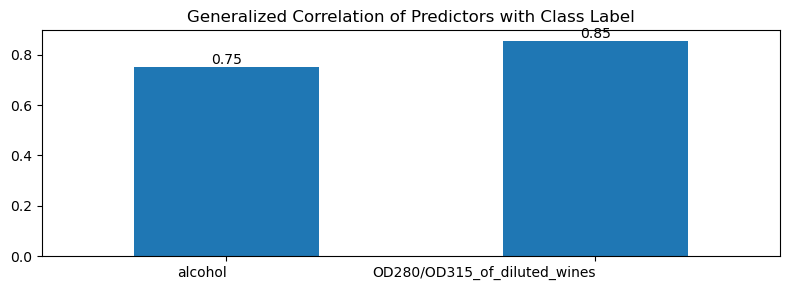

In [12]:
correlations = df_train.drop('class_label', axis=1).apply(
    lambda x: compute_generalized_correlation(pd.get_dummies(df_train.class_label), x)
)

ax = correlations.plot.bar(
    title="Generalized Correlation of Predictors with Class Label",
    figsize=(8, 3)  # set figure size
)
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, ha='right')
plt.tight_layout()
plt.show()


``histogram of clases and features``

Here we will examine the distribution of the outcome variable (cultivar class) and the distribution of the two features (alcohol content and ODs of diluted wines).

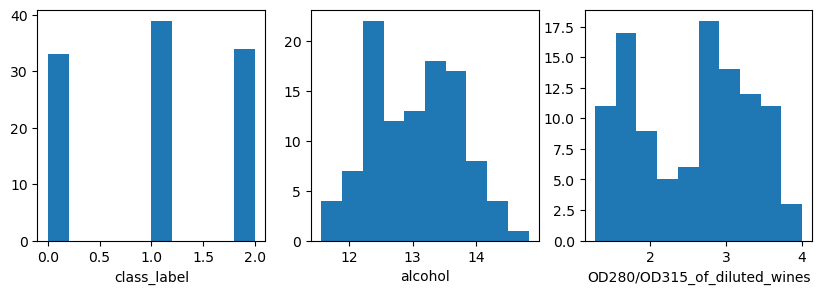

In [13]:
columns = ['class_label', 'alcohol', 'OD280/OD315_of_diluted_wines']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

<span style="color:chocolate"> *Question:*</span> As you can see from the histogram, there seems to be some class imbalance in the data. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume an equal occurrence of classes and are designed to maximize the overall classification accuracy. <span style="color:chocolate"> Suggest a way to deal with imbalanced data.</span>

---
### Step 6: Analysis - Logistic Regression with two features
---

``with TensorFlow``

Define and compile model

In [14]:
def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,), name='Input'))
    
    
    # create output layer
    model.add(keras.layers.Dense(
          units=3,  # remember it's a multiclass classification problem
          use_bias=True,
          activation='softmax', # remember it's a multiclass classification problem
          kernel_initializer=initializers.RandomNormal(stddev=0.01),
          bias_initializer=initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
  # Use Categorical Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
        metrics=['accuracy']
    )
    return model

# Build a model
model = build_model(num_features=len(features))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Output (Dense)                  │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

Model fit:

In [15]:
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train_std,
                y=y_train,
                validation_data=[X_test_std, y_test],
                #validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train_std),
                epochs=120,
                verbose=0 #silence fit
)

Show learned model

In [16]:
# Show learned model
w = model.layers[0].get_weights()[0]
b = model.layers[0].get_weights()[1]

print('Bias:', b)
print('Weights', w)

Bias: [-0.13756345  0.27144125 -0.13414824]
Weights [[ 1.039939   -1.2211887   0.18043445]
 [ 1.0375626   0.48344633 -1.5206796 ]]


Plot model performance:

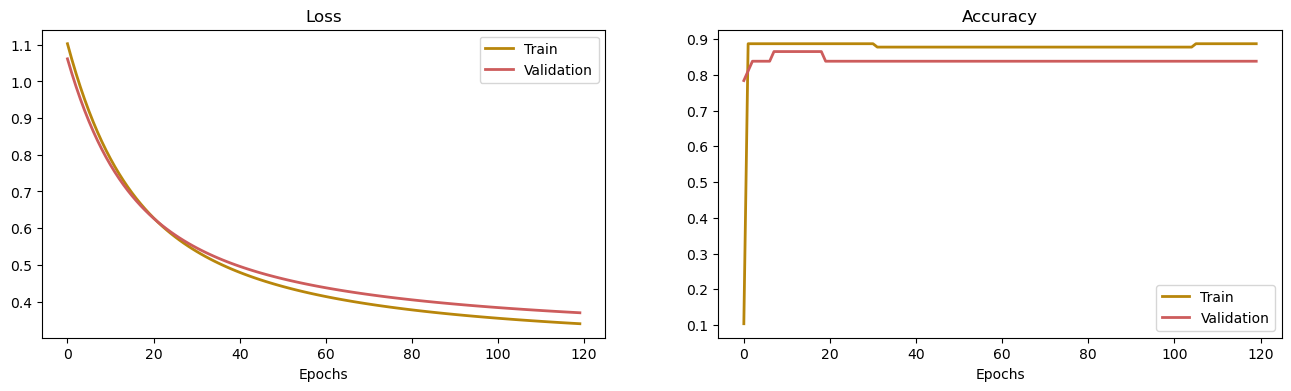

In [17]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 2, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

Evaluation (on test data)

In [18]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_tf = model.predict(x=X_test_std)

# print the predictions for the first example in test data
y_test_pred_tf[0]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


array([0.01171789, 0.9808768 , 0.00740521], dtype=float32)

A prediction is an array of 3 numbers. They represent the model's "confidence" that the example corresponds to each of the 3 different cultivar classes. You can see which label has the highest confidence value for the first example in test data:

In [19]:
print("predicted label:", np.argmax(y_test_pred_tf[0]))

predicted label: 1


So, the model is most confident that this example is cultivar 0. Examining the ground truth test label shows that this classification is correct:

In [20]:
# compare with the actual values (ground truth) in test data
print("ground truth label:", np.argmax(y_test[0]))

ground truth label: 0


Next, let's plot the first 15 examples in the test data, their predicted labels, and the true labels.  Color correct predictions in blue and incorrect predictions in red.

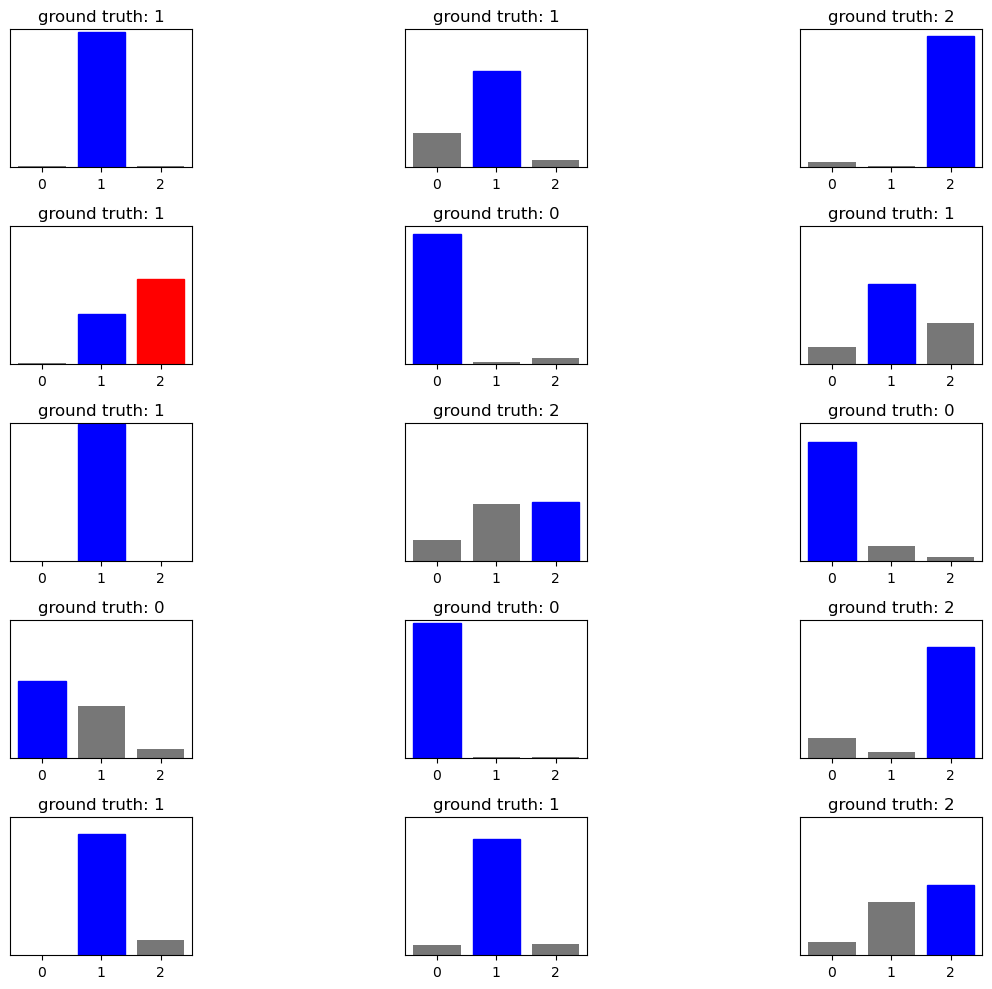

In [21]:
num_rows = 5
num_cols = 3
num_examples = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_examples):
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred_tf[i], y_test) # this function is defined at the top of the notebook

    
plt.tight_layout()
plt.show()

Evaluation - cont'd (on training and test data)

In [22]:
### print accuracy for training
y_train_pred_tf = model.predict(x=X_train_std)

# set predicted label based on highest probability
y_train_maxpred_tf =  np.argmax(y_train_pred_tf, axis=1)

print('Train, misclassified examples: %d' % (y_train != y_train_maxpred_tf).sum())
error_train_tf = (y_train != y_train_maxpred_tf).sum()/len(y_train_maxpred_tf)
print('Train, prediction accuracy: %.3f'% (1-error_train_tf))

### print accuracy for test
y_test_pred_tf = model.predict(x=X_test_std)

# set predicted label based on highest probability
y_test_maxpred_tf =  np.argmax(y_test_pred_tf, axis=1)

print('Test, misclassified examples: %d' % (y_test != y_test_maxpred_tf).sum())
error_test_tf = (y_test != y_test_maxpred_tf).sum()/len(y_test_maxpred_tf)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
Train, misclassified examples: 12
Train, prediction accuracy: 0.887
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
Test, misclassified examples: 6
Test, prediction accuracy: 0.838


In [23]:
# plot confusion matrix for test data
conf_matrix = tf.math.confusion_matrix(
    y_test,
    y_test_maxpred_tf,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 9,  4,  0],
       [ 0, 14,  2],
       [ 0,  0,  8]], dtype=int32)>

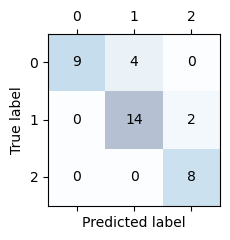

In [24]:
confusion_matrix_plot(conf_matrix.numpy())

<span style="color:chocolate"> *Question:*</span> Which class is the most difficult for the Logistic Regression model to recognize?

In [25]:
# compute precision and recall for test data, for each class # use sklearn
print("Class-wise precision:", precision_score(y_test, y_test_maxpred_tf, average=None))
print("Class-wise recall:", recall_score(y_test, y_test_maxpred_tf, average=None))

Class-wise precision: [1.         0.77777778 0.8       ]
Class-wise recall: [0.69230769 0.875      1.        ]


Interpretation: 

Precision: Out of all predicted positive examples, how many were actually positive? (TP/(TP+FP)).

Recall: Out of all actual positive examples, how many did the model correctly identify? (TP/(TP+FN)).


**Class 0**

Precision = 1.00: Every prediction the model made for class 0 was correct (no false positives).

Recall = 0.692: Only 69% of true class 0 examples were correctly identified (i.e., some false negatives).

The model misses many true class 0 instances (low recall) but doesn't assigns other class examples to it (perfect precision).

**Class 1**

Precision = 0.778: About 22% of predictions for class 1 were actually incorrect (false positives).

Recall = 0.875: The model found 87.5% of true class 1 examples (12.5% false negatives).

Balanced but imperfect performance. Some mislabeling in both directions.

**Class 2**

Precision = 0.800: 80% of predicted class 2 labels were correct.

Recall = 1.000: The model correctly found all the true class 2 examples.

The model never misses class 2 examples, but occasionally misclassifies other classes as class 2.

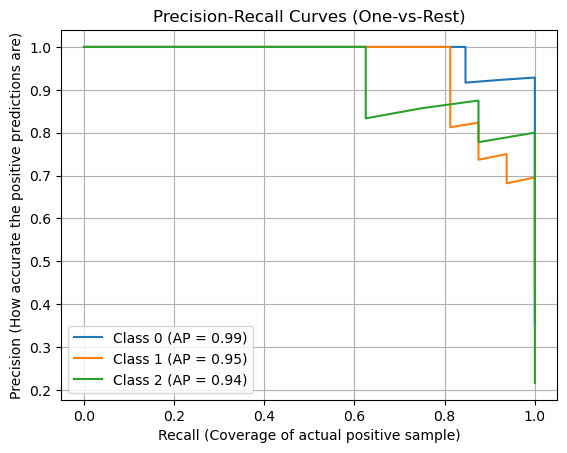

In [26]:
# compute PR curve for test data

# binarize true labels for one-vs-rest PR curves
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# precision-recall curve per class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_test_pred_tf[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_test_pred_tf[:, i])
    
    plt.plot(recall, precision, label=f'Class {i} (AP = {ap_score:.2f})')

plt.xlabel('Recall (Coverage of actual positive sample)')
plt.ylabel('Precision (How accurate the positive predictions are)')
plt.title('Precision-Recall Curves (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.show()
